In [190]:
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import respy as rp
import numpy as np

params, options, df = rp.get_example_model("robinson", with_data=True)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [191]:
params.head(50)

value
category                name                       
delta                   delta                 0.950
wage_fishing            exp_fishing           0.189
nonpec_fishing          constant             -1.000
nonpec_hammock          constant              2.500
shocks_sdcorr           sd_fishing            1.200
                        sd_hammock            1.000
                        corr_hammock_fishing  0.000
lagged_choice_1_hammock constant              1.000

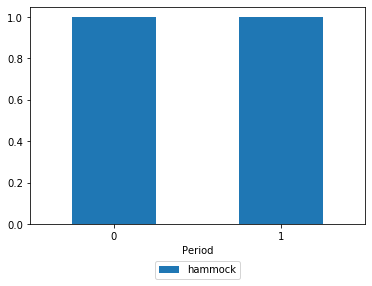

In [192]:
fig, ax = plt.subplots()

df.groupby("Period").Choice.value_counts(normalize=True).unstack().plot.bar(
    stacked=True, ax=ax
)


plt.xticks(rotation="horizontal")

plt.legend(loc="lower center", bbox_to_anchor=(0.5,-0.275), ncol=2)

plt.show()
plt.close()


In [193]:
crit_func = rp.get_crit_func(params, options, df)
crit_func(params)

-3.31993826894732

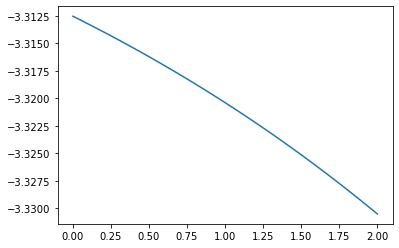

In [194]:
deltas = np.linspace(0.0, 2.0, 100)
fvals = list()
for delta in deltas:
    params.loc[("wage_fishing", "exp_fishing"), :] = delta
    fvals.append(crit_func(params))
plt.plot(deltas, fvals)